# **Predicción de género cinematográfico con PLN clásico**

In [1]:
!pip install spacy tqdm pandas scikit-learn matplotlib seaborn textblob
!python -m spacy download es_core_news_sm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 109.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import pandas as pd
import numpy as np
import re
import time
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

import spacy

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')

from tqdm import tqdm

# Configuración visual
pd.set_option('display.max_colwidth', 200)
sns.set(style="whitegrid", palette="pastel")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# Montar Google Drive y cargar el CSV desde tu carpeta PLN_Proyecto
from google.colab import drive
drive.mount('/content/drive')

# Ruta a tu archivo (ajusta el nombre del CSV real)
file_path = "/content/drive/MyDrive/PLN_Proyecto/data/reviews_filmaffinity_limpio.csv"

# Cargar el dataset
df = pd.read_csv(file_path)

print("Dimensiones:", df.shape)
df.head()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dimensiones: (8603, 6)


,film_name,gender,film_avg_rate,review_rate,review_title,review_text
0,Ocho apellidos vascos,Comedia,6.0,3.0,OCHO APELLIDOS VASCOS...Y NINGÚN NOMBRE PROPIO,La mayor virtud de esta película es su existencia.El hecho de que podamos jugar con los tópicos más extremos de las identidades patrias (la andaluza y la vasca) sin que nadie se escandalice ni pon...
1,Ocho apellidos vascos,Comedia,6.0,2.0,El perro verde,"No soy un experto cinéfilo, pero pocas veces me había sentido tan fuera de juego en una sala de cine: un auténtico perro verde. Leyendo las críticas en Filmaffinity, esta sensación se acrecienta, ..."
2,Ocho apellidos vascos,Comedia,6.0,2.0,Si no eres de comer mierda... no te comas esta mierda,"Si no eres un incondicional del humor estilo Tele 5.Si no terminas de captar de qué se ríen los adolescentes granulentos de tu familia.Si eres más de David Navarro que de Dani Rovira.Si lo de ""Eus..."
3,Ocho apellidos vascos,Comedia,6.0,2.0,Aida: The movie,"No sé qué está pasando, si la gente se deja llevar por las modas, si de verdad les gusta o sólo van porque les pone Dani Rovira, pero el éxito desmedido de Ocho apellidos vascos me tiene sorprendi..."
4,Ocho apellidos vascos,Comedia,6.0,2.0,UN HOMBRE SOLO (Julio Iglesias 1987),"""Pero cuando amanece,y me quedo solo,siento en el fondoun mar vacío,un seco río,que grita y gritaque sólo soyun hombre solo,un hombre solo,un hombre solo"".Pues bien, después de ver esta película e..."


# **Exploración Exploratorio Inicial**


Valores nulos:
 film_name        0
gender           0
film_avg_rate    0
review_rate      2
review_title     0
review_text      0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8603 entries, 0 to 8602
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   film_name      8603 non-null   object 
 1   gender         8603 non-null   object 
 2   film_avg_rate  8603 non-null   float64
 3   review_rate    8601 non-null   float64
 4   review_title   8603 non-null   object 
 5   review_text    8603 non-null   object 
dtypes: float64(2), object(4)
memory usage: 403.4+ KB
None
gender
Comedia       2495
Drama         1671
Terror         941
Aventuras      939
Thriller       762
Fantástico     495
Cine negro     419
Romance        284
Animación      284
Intriga        248
Musical         65
Name: count, dtype: int64

Promedio de puntuación por género:
 gender
Fantástico    7.242424
Cine negro    6.863962
Drama  

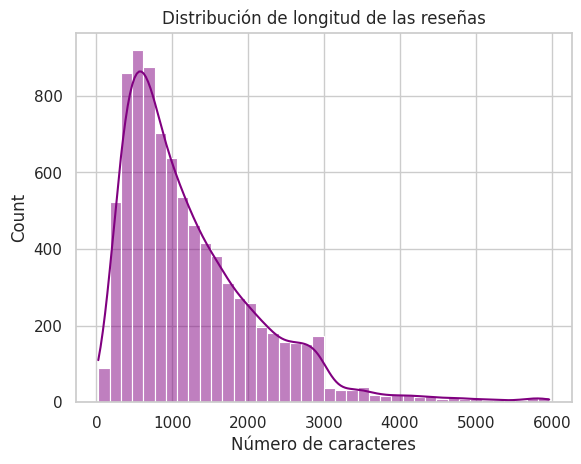

In [ ]:
# Revisar valores nulos
null = df.isnull().sum()
print("\nValores nulos:\n", null)

print(df.info())
print(df['gender'].value_counts())

# Promedio de calificaciones por género
promedio = df.groupby('gender')['review_rate'].mean().sort_values(ascending=False)
print("\nPromedio de puntuación por género:\n", promedio)

# Longitud promedio de los textos
df['text_length'] = df['review_text'].astype(str).apply(len)
sns.histplot(df['text_length'], bins=40, kde=True, color="purple")
plt.title("Distribución de longitud de las reseñas")
plt.xlabel("Número de caracteres")
plt.show()

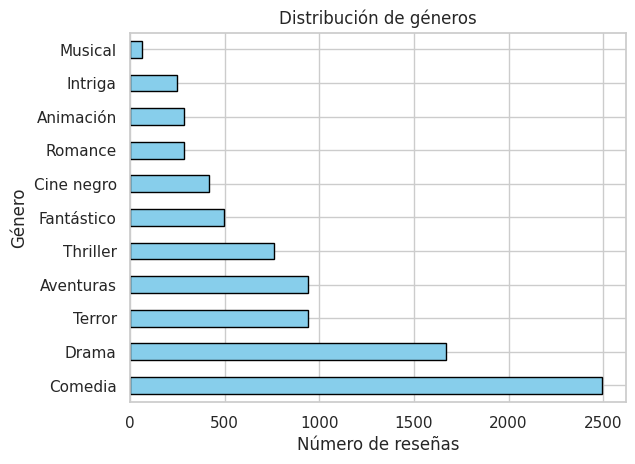

In [ ]:
# Distribución de géneros
df['gender'].value_counts().plot(kind='barh', color='skyblue', edgecolor='black')
plt.title("Distribución de géneros")
plt.ylabel("Género")
plt.xlabel("Número de reseñas")
plt.show()


# **Preprocesamiento de texto**


In [ ]:
# Cargar modelo de spaCy en español (modelo pequeño)
nlp = spacy.load("es_core_news_sm", disable=["ner", "parser"])
stop_words = nlp.Defaults.stop_words

# Limpieza inicial simple
def limpiar_texto_basico(text):
    text = str(text).lower()
    text = re.sub(r'[^a-záéíóúñü ]', ' ', text)  # mantener solo letras y espacios
    return text

# Pre-limpieza rápida sin lematización
df['temp_clean'] = df['review_text'].apply(limpiar_texto_basico)

# Procesar en lotes con spaCy.pipe (rápido y eficiente)
texts = df['temp_clean'].tolist()
cleaned_texts = []

print("Procesando textos con spaCy...")

for doc in tqdm(nlp.pipe(texts, batch_size=50)):
    tokens = [
        token.lemma_ for token in doc
        if token.lemma_ not in stop_words
        and not token.is_punct
        and len(token) > 2
    ]
    cleaned_texts.append(" ".join(tokens))

df['clean_text'] = cleaned_texts

# Limpieza final: eliminar columna temporal para liberar memoria
df.drop(columns=['temp_clean'], inplace=True)

# Vista previa del resultado
df[['review_text', 'clean_text']].head()


Procesando textos con spaCy...


8603it [02:23, 60.11it/s]


,review_text,clean_text
0,La mayor virtud de esta película es su existencia.El hecho de que podamos jugar con los tópicos más extremos de las identidades patrias (la andaluza y la vasca) sin que nadie se escandalice ni pon...,virtud película existencia jugar tópico extremo identidad patrio andaluza vasco escandalizar grito cielo indicar madurez nación pese pese corrijo jugar mofa befa tópico vasco nacionalismo vasco es...
1,"No soy un experto cinéfilo, pero pocas veces me había sentido tan fuera de juego en una sala de cine: un auténtico perro verde. Leyendo las críticas en Filmaffinity, esta sensación se acrecienta, ...",experto cinéfilo sentir juego sala cine auténtico perro verde leer crítica filmaffinity sensación acrecentar coger tono atornasolado película gustar honroso excepción situación francamente broma o...
2,"Si no eres un incondicional del humor estilo Tele 5.Si no terminas de captar de qué se ríen los adolescentes granulentos de tu familia.Si eres más de David Navarro que de Dani Rovira.Si lo de ""Eus...",incondicional humor estilo tele termina captar reir adolescente granulento familia david navarro dani rovira euskadi color especial parecer hallazgo siglo risita peíto sentir vergüenza ajenar repe...
3,"No sé qué está pasando, si la gente se deja llevar por las modas, si de verdad les gusta o sólo van porque les pone Dani Rovira, pero el éxito desmedido de Ocho apellidos vascos me tiene sorprendi...",pasar gente dejar moda gustar dani rovira éxito desmedido apellido vasco sorprendido convertir película taquillero año quedar camino ver él realmente estár producto genial fresco inteligente pelíc...
4,"""Pero cuando amanece,y me quedo solo,siento en el fondoun mar vacío,un seco río,que grita y gritaque sólo soyun hombre solo,un hombre solo,un hombre solo"".Pues bien, después de ver esta película e...",amanecer quedo sentir fondoun mar vacío seco río gritar gritaque soyun hombre hombre hombre película sentir hombre rodeado gente masa cine película reer disfrutar dejar entusiasmar él recordar gag...


Se lematiza cada palabra, se eliminan stopwords, se filtran palabras cortas, generando textos como:

**"virtud película existencia jugar tópico extremo identidad patrio andaluza vasco escandalizar..."**

Las cuales son listas de palabras lematizadas, pero sin coherencia ni matices, por lo cual no se conserva la estructura de la reseña ni conectores clave.

### **Observación sobre pérdida de coherencia**

La lematización reduce las palabras a su forma base, lo cual puede eliminar matices importantes del lenguaje. En tareas como clasificación de géneros, esto puede afectar la capacidad del modelo para captar el estilo narrativo o emocional de la reseña. Por ejemplo, frases como "no me gustó" pueden perder su sentido si se eliminan conectores o negaciones.


In [ ]:
# Cargar modelo de spaCy en español
nlp = spacy.load("es_core_news_sm", disable=["ner", "parser"])
stop_words = nlp.Defaults.stop_words

# Limpieza inicial simple
def limpiar_texto_basico(text):
    text = str(text).lower()
    text = re.sub(r'[^a-záéíóúñü ]', ' ', text)  # mantener solo letras y espacios
    return text

# Aplicar limpieza básica
df['temp_clean'] = df['review_text'].apply(limpiar_texto_basico)

# Procesar en lotes sin lematizar
texts = df['temp_clean'].tolist()
cleaned_texts = []

print("Procesando textos con spaCy... (sin lematización)")

for doc in tqdm(nlp.pipe(texts, batch_size=50)):
    tokens = [
        token.text for token in doc
        if token.text not in stop_words
        and not token.is_punct
        and len(token.text) > 2
    ]
    cleaned_texts.append(" ".join(tokens))

df['clean_text'] = cleaned_texts

# Eliminar columna temporal
df.drop(columns=['temp_clean'], inplace=True)

# Vista previa
df[['review_text', 'clean_text']].head()


Procesando textos con spaCy... (sin lematización)


8603it [02:28, 58.05it/s]


,review_text,clean_text
0,La mayor virtud de esta película es su existencia.El hecho de que podamos jugar con los tópicos más extremos de las identidades patrias (la andaluza y la vasca) sin que nadie se escandalice ni pon...,virtud película existencia podamos jugar tópicos extremos identidades patrias andaluza vasca escandalice ponga grito cielo indica madurez nación pese pese corrijo podamos jugar mofa befa tópicos v...
1,"No soy un experto cinéfilo, pero pocas veces me había sentido tan fuera de juego en una sala de cine: un auténtico perro verde. Leyendo las críticas en Filmaffinity, esta sensación se acrecienta, ...",experto cinéfilo sentido juego sala cine auténtico perro verde leyendo críticas filmaffinity sensación acrecienta cogiendo tonos atornasolados película gustó honrosa excepción situación francament...
2,"Si no eres un incondicional del humor estilo Tele 5.Si no terminas de captar de qué se ríen los adolescentes granulentos de tu familia.Si eres más de David Navarro que de Dani Rovira.Si lo de ""Eus...",incondicional humor estilo tele terminas captar ríen adolescentes granulentos familia david navarro dani rovira euskadi color especial hallazgo siglo risitas peíto has sentido vergüenza ajena repe...
3,"No sé qué está pasando, si la gente se deja llevar por las modas, si de verdad les gusta o sólo van porque les pone Dani Rovira, pero el éxito desmedido de Ocho apellidos vascos me tiene sorprendi...",pasando gente deja modas gusta pone dani rovira éxito desmedido apellidos vascos sorprendido convertido película taquillera año queda camino verla realmente estábamos producto genial fresco inteli...
4,"""Pero cuando amanece,y me quedo solo,siento en el fondoun mar vacío,un seco río,que grita y gritaque sólo soyun hombre solo,un hombre solo,un hombre solo"".Pues bien, después de ver esta película e...",amanece quedo siento fondoun mar vacío seco río grita gritaque soyun hombre hombre hombre película siento hombre rodeado gente masa ido cines película reído disfrutado deja entusiasmarse recordand...


Aunque los resultados sin lematización conservan más matices que la versión anterior, la eliminación de stopwords sigue afectando la coherencia narrativa, se rompe la estructura lógica y emocional de las frases.


Al no eliminar stopwords se conservan conectores, negaciones y estructura gramatical. El texto mantiene su flujo narrativo, lo que puede ayudar al modelo a captar patrones más ricos **pero se introduce más ruido (palabras frecuentes que aparecen en todos los textos)**.

Si se realiza la extracción de características (feature engineering)  usando TF-IDF (técnica de vectorización), el cual penaliza las palabras comunes que aparecen en muchos documentos => se pueden conservar las stopwords porque este método ya se encarga de reducir su peso.

```
TF-IDF = Term Frequency – Inverse Document Frequency

Es una técnica que asigna peso a cada palabra según:

- TF (frecuencia en el documento): cuántas veces aparece la palabra en una reseña

- IDF (frecuencia inversa en el corpus): cuántos documentos contienen esa palabra

La fórmula penaliza las palabras que aparecen en muchos documentos, porque se consideran menos informativas.
```


In [ ]:
# Cargar modelo de spaCy en español (modelo pequeño)
nlp = spacy.load("es_core_news_sm", disable=["ner", "parser"])

# Limpieza inicial simple
def limpiar_texto_basico(text):
    text = str(text).lower()
    text = re.sub(r'[^a-záéíóúñü ]', ' ', text)  # mantener solo letras y espacios
    return text

# Aplicar limpieza básica
df['temp_clean'] = df['review_text'].apply(limpiar_texto_basico)

# Procesar en lotes sin lematizar y sin eliminar stopwords ni palabras cortas
texts = df['temp_clean'].tolist()
cleaned_texts = []

print("Procesando textos con spaCy... (sin lematización, sin eliminación de stopwords ni palabras cortas)")

for doc in tqdm(nlp.pipe(texts, batch_size=50)):
    tokens = [
        token.text for token in doc
        if not token.is_punct and token.text.strip() != ""
    ]
    cleaned_texts.append(" ".join(tokens))

# Guardar resultado final
df['clean_text'] = cleaned_texts

# Eliminar columna temporal para liberar memoria
df.drop(columns=['temp_clean'], inplace=True)

# Vista previa del resultado
df[['review_text', 'clean_text']].head()


Procesando textos con spaCy... (sin lematización, sin eliminación de stopwords ni palabras cortas)


8603it [02:22, 60.35it/s]


,review_text,clean_text
0,La mayor virtud de esta película es su existencia.El hecho de que podamos jugar con los tópicos más extremos de las identidades patrias (la andaluza y la vasca) sin que nadie se escandalice ni pon...,la mayor virtud de esta película es su existencia el hecho de que podamos jugar con los tópicos más extremos de las identidades patrias la andaluza y la vasca sin que nadie se escandalice ni ponga...
1,"No soy un experto cinéfilo, pero pocas veces me había sentido tan fuera de juego en una sala de cine: un auténtico perro verde. Leyendo las críticas en Filmaffinity, esta sensación se acrecienta, ...",no soy un experto cinéfilo pero pocas veces me había sentido tan fuera de juego en una sala de cine un auténtico perro verde leyendo las críticas en filmaffinity esta sensación se acrecienta y voy...
2,"Si no eres un incondicional del humor estilo Tele 5.Si no terminas de captar de qué se ríen los adolescentes granulentos de tu familia.Si eres más de David Navarro que de Dani Rovira.Si lo de ""Eus...",si no eres un incondicional del humor estilo tele si no terminas de captar de qué se ríen los adolescentes granulentos de tu familia si eres más de david navarro que de dani rovira si lo de euskad...
3,"No sé qué está pasando, si la gente se deja llevar por las modas, si de verdad les gusta o sólo van porque les pone Dani Rovira, pero el éxito desmedido de Ocho apellidos vascos me tiene sorprendi...",no sé qué está pasando si la gente se deja llevar por las modas si de verdad les gusta o sólo van porque les pone dani rovira pero el éxito desmedido de ocho apellidos vascos me tiene sorprendido ...
4,"""Pero cuando amanece,y me quedo solo,siento en el fondoun mar vacío,un seco río,que grita y gritaque sólo soyun hombre solo,un hombre solo,un hombre solo"".Pues bien, después de ver esta película e...",pero cuando amanece y me quedo solo siento en el fondoun mar vacío un seco río que grita y gritaque sólo soyun hombre solo un hombre solo un hombre solo pues bien después de ver esta película es a...


Se optó por conservar las stopwords y las palabras cortas en el preprocesamiento para preservar la coherencia narrativa de las reseñas. Esta decisión se fundamenta en el uso de TF-IDF como técnica de vectorización, la cual penaliza automáticamente las palabras comunes que aparecen en la mayoría de los documentos. Al mantener el texto completo, se busca que el modelo pueda captar mejor los matices lingüísticos, emocionales y estructurales que caracterizan cada género cinematográfico.


> **Se utilizó spaCy para tokenizar y limpiar el texto, eliminando signos de puntuación y otros elementos no deseados. Posteriormente, se reconstruyó el texto limpio como string para facilitar la vectorización con `TfidfVectorizer,` el cual aplica su propia tokenización interna. Al no especificar parámetros, se utilizó la configuración por defecto, que considera unigramas y calcula el peso TF-IDF de cada palabra individual.**





# **Análisis Exploratorio post-preprocesamiento**





In [ ]:
# Palabras más frecuentes por género
for g in df['gender'].unique():
    words = " ".join(df[df['gender'] == g]['clean_text']).split()
    common = Counter(words).most_common(10)
    print(f"\nGénero: {g}")
    print(common)



Género: Comedia
[('de', 26773), ('que', 22249), ('la', 17444), ('y', 16287), ('en', 11435), ('el', 11110), ('a', 10285), ('es', 8125), ('no', 7815), ('un', 7244)]

Género: Drama
[('de', 20392), ('que', 15918), ('la', 14397), ('y', 11911), ('en', 9106), ('el', 8462), ('a', 7720), ('es', 5557), ('no', 5531), ('una', 5209)]

Género: Terror
[('de', 9998), ('que', 8437), ('la', 6489), ('y', 5409), ('el', 4549), ('en', 4503), ('a', 3672), ('es', 3032), ('no', 3008), ('una', 2674)]

Género: Aventuras
[('de', 11828), ('que', 9669), ('la', 8570), ('y', 6694), ('en', 5426), ('el', 5002), ('a', 4283), ('no', 3955), ('es', 3468), ('los', 3112)]

Género: Animación
[('de', 3538), ('que', 2737), ('la', 2289), ('y', 2015), ('en', 1622), ('el', 1475), ('a', 1433), ('es', 1066), ('un', 1018), ('los', 970)]

Género: Thriller
[('de', 8319), ('que', 7039), ('la', 5167), ('y', 4815), ('en', 4100), ('el', 3821), ('a', 3188), ('un', 2731), ('no', 2435), ('es', 2316)]

Género: Musical
[('de', 391), ('que', 36

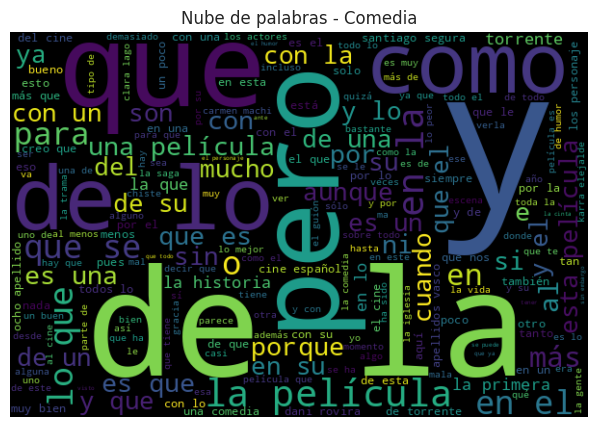

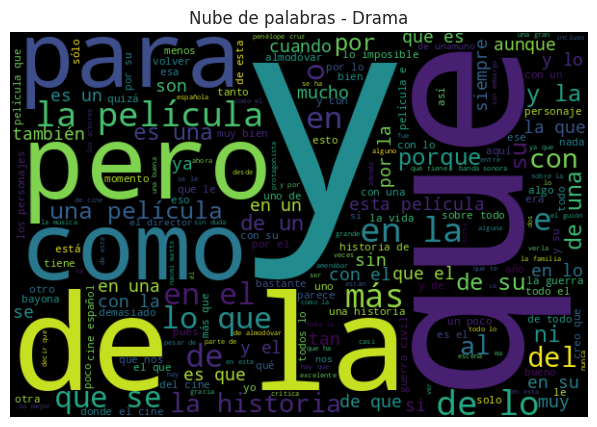

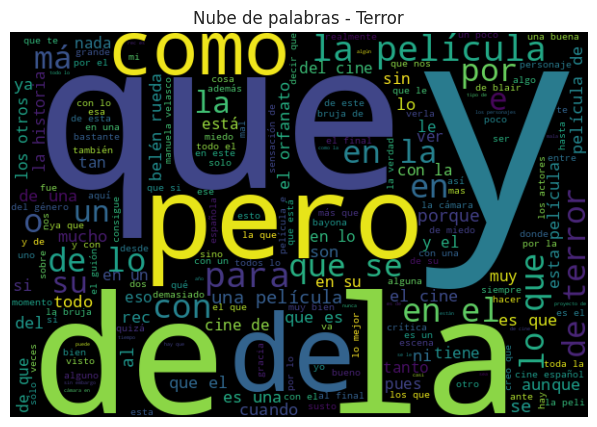

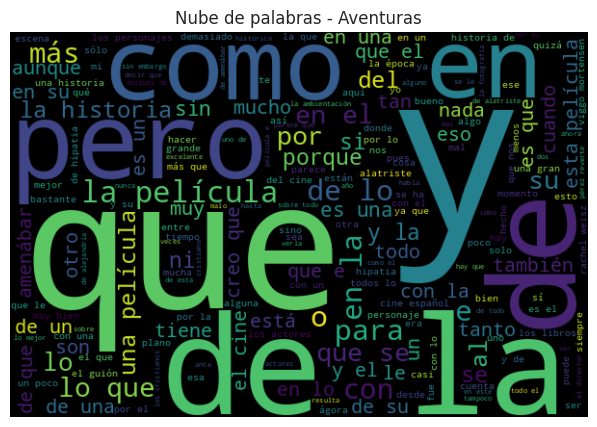

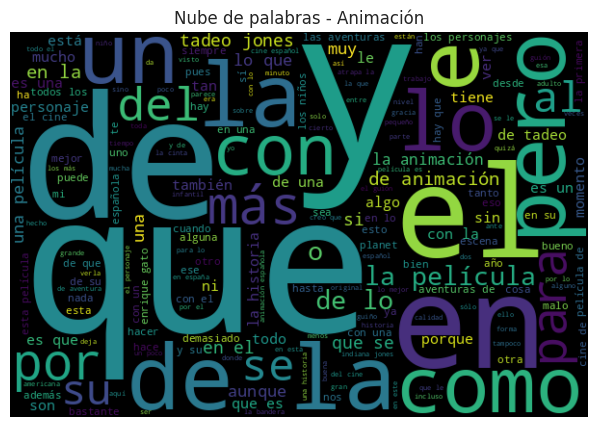

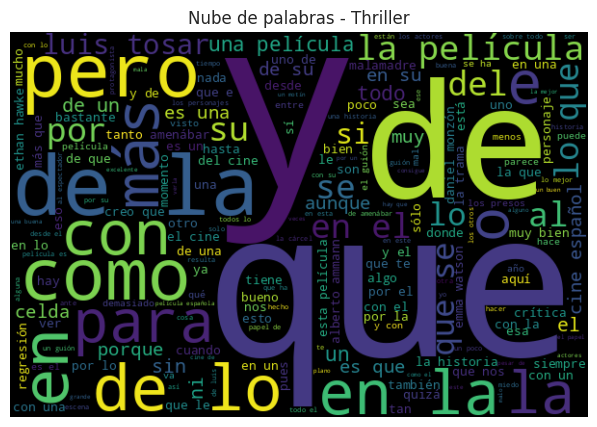

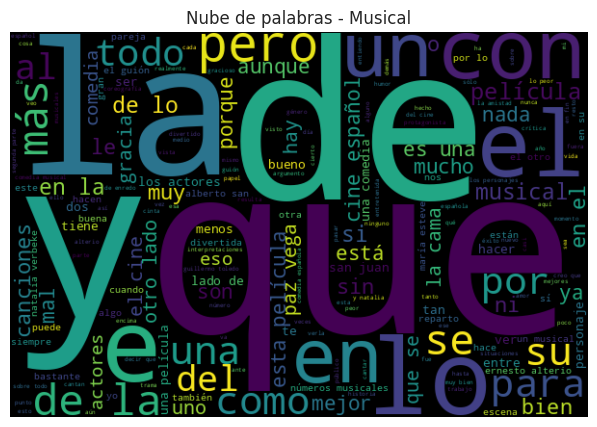

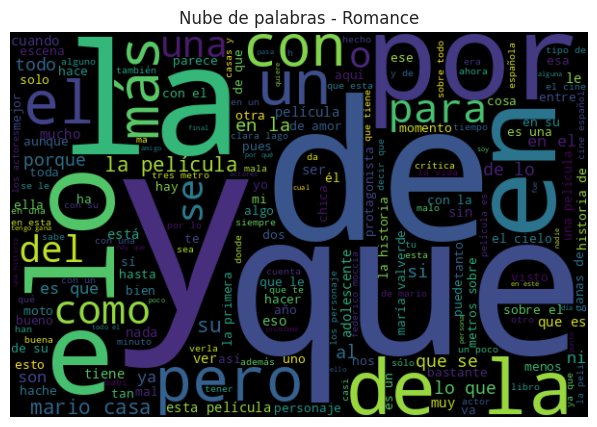

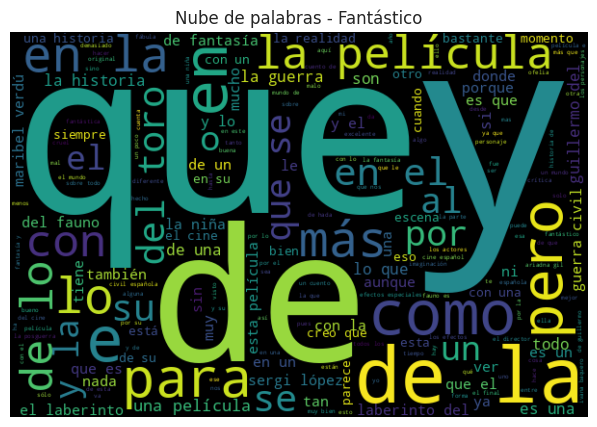

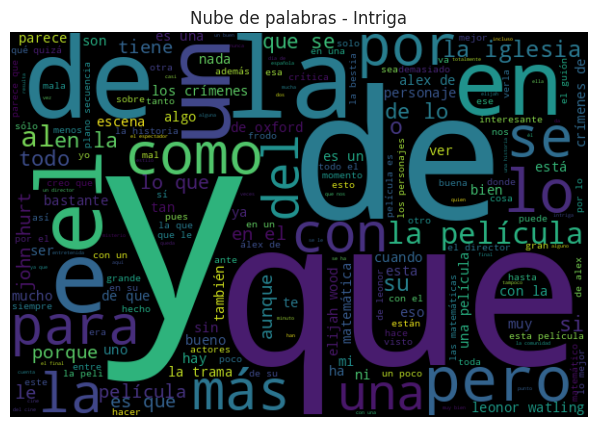

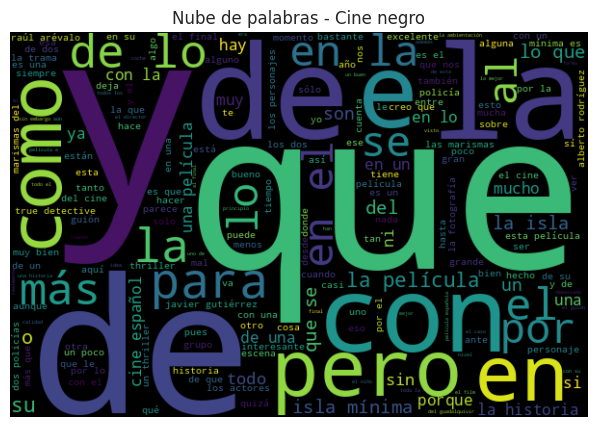

In [ ]:
# Nube de palabras
for g in df['gender'].unique():
    text = " ".join(df[df['gender'] == g]['clean_text'])
    wc = WordCloud(width=600, height=400, background_color='black').generate(text)
    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Nube de palabras - {g}')
    plt.show()

Las nubes de palabras por género revelan que, a pesar de la presencia dominante de stopwords, cada categoría presenta vocabulario temático distintivo. Palabras como *“terror”, “amor”, “aventura”, “musical” o “crímenes”* aparecen con mayor frecuencia en sus respectivos géneros, lo que sugiere que el modelo puede aprender patrones semánticos relevantes.

Esta observación refuerza la decisión de conservar las stopwords en el texto limpio, confiando en que TF-IDF penalizará su peso y permitirá que los términos informativos destaquen en el proceso de clasificación.

#### Palabras temáticas visibles por género:

| Género        | Palabras temáticas visibles                                      |
|---------------|------------------------------------------------------------------|
| **Comedia**   | película, porque, torrente, bueno                                |
| **Drama**     | yo, historia, vida, personaje, volver                            |
| **Terror**    | bruja, cámara, miedo, terror, oscuro                             |
| **Aventuras** | historia, época, aventura, acción                                |
| **Animación** | tadeo, animación, personajes, aventura                           |
| **Thriller**  | celda, regresión, crítica, español                               |
| **Musical**   | musical, canciones, actores, comedia                             |
| **Romance**   | amor, pareja, primera, casa                                      |
| **Fantástico**| laberinto, fauno, fantasía, guerra                               |
| **Intriga**   | crímenes, trama, escena, asesinato                               |
| **Cine negro**| isla, historia, cine, español                                    |


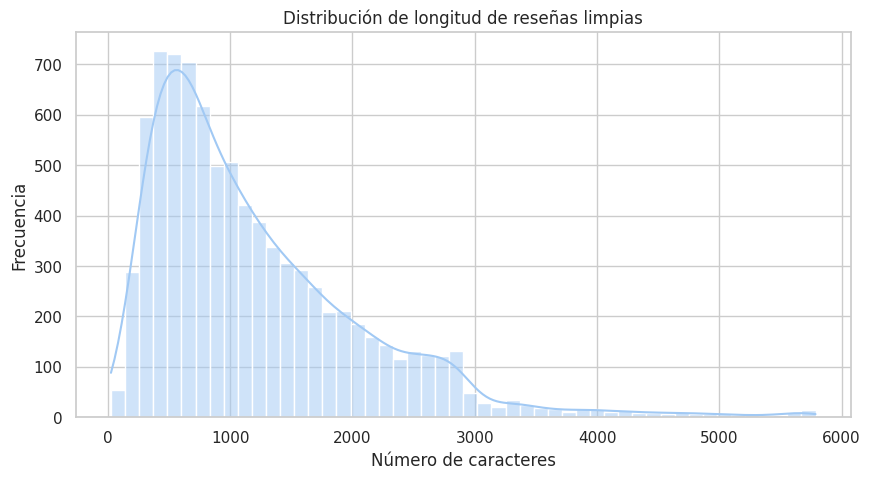

In [ ]:
import seaborn as sns

df['longitud'] = df['clean_text'].str.len()

plt.figure(figsize=(10, 5))
sns.histplot(df['longitud'], bins=50, kde=True)
plt.title("Distribución de longitud de reseñas limpias")
plt.xlabel("Número de caracteres")
plt.ylabel("Frecuencia")
plt.show()


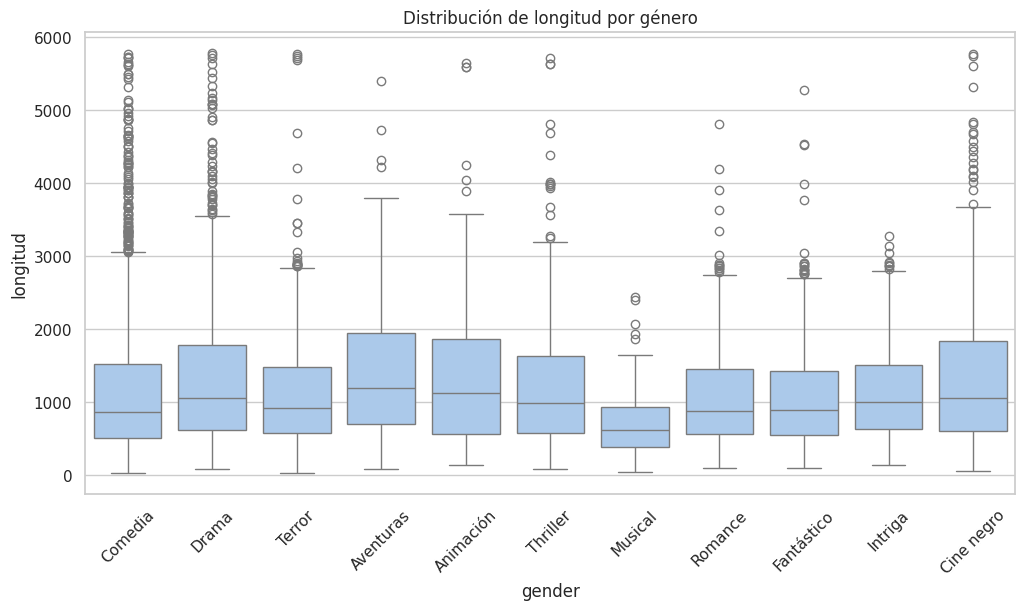

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='gender', y='longitud', data=df)
plt.xticks(rotation=45)
plt.title("Distribución de longitud por género")
plt.show()


El boxplot por género revela que las reseñas de géneros como **Drama y Cine negro** tienden a ser más extensas, con mayor variabilidad en longitud. En contraste, géneros como **Musical y Animación** presentan reseñas más breves y homogéneas. Esta diferencia puede estar relacionada con el estilo narrativo de las películas o con el tipo de análisis que realizan los usuarios en sus comentarios.

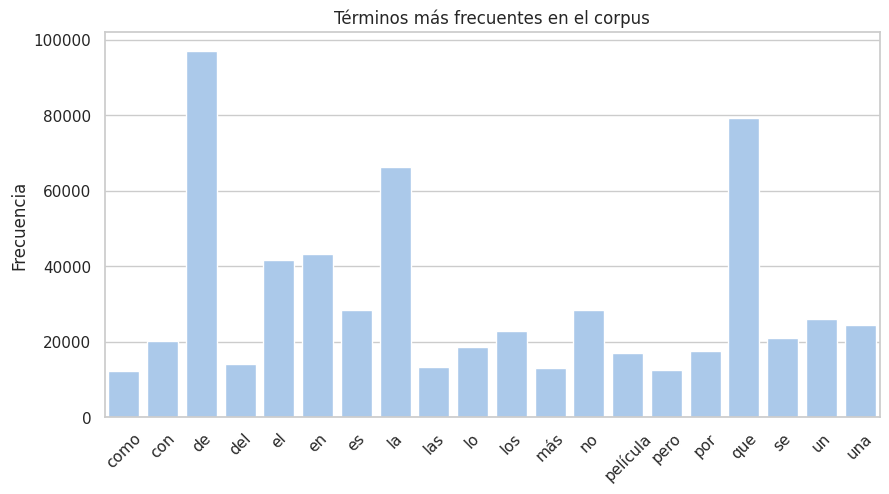

In [ ]:
# Frecuencia de términos más comunes (CountVectorizer)
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_features=20)
X = vectorizer.fit_transform(df['clean_text'])

# Mostrar las 20 palabras más frecuentes
palabras = vectorizer.get_feature_names_out()
frecuencias = X.toarray().sum(axis=0)

plt.figure(figsize=(10, 5))
sns.barplot(x=palabras, y=frecuencias)
plt.xticks(rotation=45)
plt.title("Términos más frecuentes en el corpus")
plt.ylabel("Frecuencia")
plt.show()

Las palabras más comunes son **stopwords** como *“de”, “que”, “la”, “y”, “en”*

Esto confirma que **TF-IDF será útil** para penalizar estas palabras automáticamente

También aparecen términos clave como **“película”, “no”, “pero”**, que aportan valor semántico

In [ ]:
# Comparación entre géneros en vocabulario y estilo
# Agrupar textos por género
textos_por_genero = df.groupby('gender')['clean_text'].apply(lambda x: " ".join(x))

# Vectorizar por género
vectorizador = CountVectorizer(max_features=15)
X_gen = vectorizador.fit_transform(textos_por_genero)

# Mostrar como DataFrame
import pandas as pd
df_vocab = pd.DataFrame(X_gen.toarray(), index=textos_por_genero.index, columns=vectorizador.get_feature_names_out())
df_vocab.T.sort_values(by='Comedia', ascending=False).head(10)


gender,Animación,Aventuras,Cine negro,Comedia,Drama,Fantástico,Intriga,Musical,Romance,Terror,Thriller
de,3538,11828,5365,26773,20392,4802,2811,391,2881,9998,8319
que,2737,9669,4145,22249,15918,3885,2196,361,2776,8437,7039
la,2289,8570,3966,17444,14397,3811,1907,242,2072,6489,5167
en,1622,5426,2501,11435,9106,2151,1060,186,1186,4503,4100
el,1475,5002,2429,11110,8462,2198,1273,190,1171,4549,3821
es,1066,3468,1375,8125,5557,1481,802,158,990,3032,2316
no,968,3955,1382,7815,5531,1285,922,165,1036,3008,2435
un,1018,2918,1527,7244,5181,1366,810,116,765,2510,2731
una,830,3004,1295,6308,5209,1583,600,106,699,2674,2074
los,970,3112,1417,6207,4475,1261,552,121,521,2276,2005


Todos los géneros comparten una base de palabras frecuentes, pero con **diferencias en proporciones**

Por ejemplo:

*   “no” aparece más en **Comedia** y **Drama**, lo que puede reflejar tono crítico o humorístico

*   “una” y “los” tienen más presencia en **Comedia**, **Romance** y** Cine negro**

Esto sugiere que el vocabulario puede ser indicativo del género, incluso si incluye stopwords.

In [ ]:
# Longitud promedio de reseñas
df['longitud'] = df['clean_text'].apply(lambda x: len(x.split()))
print(df['longitud'].describe())

count    8603.000000
mean      215.565035
std       156.015863
min         5.000000
25%       101.000000
50%       172.000000
75%       291.000000
max      1062.000000
Name: longitud, dtype: float64


La mayoría de las reseñas son relativamente cortas, con una distribución sesgada a la derecha (cola larga).

Esto indica que el modelo debe ser capaz de trabajar con textos breves y algunos muy extensos.

> **El análisis exploratorio posterior al preprocesamiento revela que las reseñas conservan una estructura narrativa rica, con una longitud promedio de 215 caracteres y una distribución variable según el género. Las palabras más frecuentes incluyen conectores y stopwords, lo cual refuerza la decisión de conservarlas en el texto limpio. Dado que se utiliza TF-IDF como técnica de vectorización, estas palabras comunes reciben un peso bajo, mientras que los términos distintivos por género se mantienen relevantes. La comparación de vocabulario entre géneros muestra diferencias sutiles que pueden ser aprovechadas por el modelo de clasificación.**


# **Vectorización del texto (TF-IDF)**

División inicial de los datos en entrenamiento y prueba.


In [ ]:
# Dividir datos
X = df['clean_text']
y = df['gender']

X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full,
    test_size=0.2, stratify=y_train_full, random_state=42
)


In [ ]:
vectorizer = TfidfVectorizer()

X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf   = vectorizer.transform(X_val)
X_test_tfidf  = vectorizer.transform(X_test)


print("Dimensiones del conjunto de entrenamiento:", X_train_tfidf.shape)
print("Dimensiones del conjunto de prueba:", X_val_tfidf.shape)
print("Dimensiones del conjunto de prueba:", X_test_tfidf.shape)

# Mostrar las primeras 20 palabras del vocabulario
print("Primeras palabras del vocabulario TF-IDF:")
print(vectorizer.get_feature_names_out()[:100])


Dimensiones del conjunto de entrenamiento: (5505, 46061)
Dimensiones del conjunto de prueba: (1377, 46061)
Dimensiones del conjunto de prueba: (1721, 46061)
Primeras palabras del vocabulario TF-IDF:
['aaaaaaaaaaaaaaaaaay' 'aaaaaahhhhh' 'aaahh' 'aardman' 'aaron' 'ab' 'abad'
 'abades' 'abajo' 'abalan' 'abalanzarse' 'abandera' 'abanderado'
 'abandona' 'abandonaba' 'abandonada' 'abandonado' 'abandonados'
 'abandonan' 'abandonando' 'abandonar' 'abandonara' 'abandonarla'
 'abandonarlas' 'abandonarle' 'abandonarlos' 'abandonaron' 'abandone'
 'abandonen' 'abandono' 'abandoné' 'abandonó' 'abanico' 'abaníco'
 'abaratar' 'abarca' 'abarcaba' 'abarcada' 'abarcado' 'abarcan' 'abarcar'
 'abarcarlo' 'abarcarlos' 'abarque' 'abarrota' 'abarrotaban' 'abarrotada'
 'abarrotados' 'abarrotadísimo' 'abarrotando' 'abastecen' 'abastecimiento'
 'abasto' 'abastos' 'abatido' 'abatiendo' 'abatimiento' 'abc'
 'abdominadas' 'abdominal' 'abdominales' 'abducida' 'abducido' 'abduction'
 'abel' 'aberchandal' 'aberracione

> **El corpus fue dividido en tres subconjuntos: entrenamiento (64%), validación (16%) y prueba (20%). Esta estructura permite entrenar modelos sobre el conjunto de entrenamiento, evaluar su rendimiento en validación para ajustar hiperparámetros y detectar problemas como desbalance de clases, y finalmente realizar una evaluación objetiva sobre el conjunto de prueba. La vectorización se realizó con TF-IDF sobre el texto limpio, utilizando unigramas como línea base.**
